In [2]:
import os
import torch
import pandas as pd
import numpy as np
import random
import torch.nn as nn
import time
from tqdm import tqdm
from sklearn import metrics
import gc
import torch.nn.functional as F
from glob import glob
from sklearn.model_selection import KFold
from datetime import datetime
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [3]:
SEED = 42
def seed_everything(seed):
    print(f'setting everything to seed {seed}')
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

with open('data.pkl', 'rb') as f:
    data = pickle.load(f)

print(data.keys())
print('\n')

for item in list(data.keys()):
    print(item)
    print(data[item]['data'].shape)
    print(data[item]['label'].shape)
    print('\n')

setting everything to seed 42
dict_keys(['sub_0', 'sub_1', 'sub_2', 'sub_3', 'sub_4'])


sub_0
(3397, 310)
(3397,)


sub_1
(3397, 310)
(3397,)


sub_2
(3397, 310)
(3397,)


sub_3
(3397, 310)
(3397,)


sub_4
(3397, 310)
(3397,)




In [4]:
features = [f'f_{i}' for i in range(310)]
traindata = pd.DataFrame(columns=features+['person','label'])

In [5]:
fea = []
per = []
lab = []
for item in list(data.keys()):
    per.append([item]*data[item]['data'].shape[0])
    fea.append(data[item]['data'])
    lab.append(data[item]['label'])
fea = np.concatenate(fea)
lab = np.concatenate(lab)
per = np.array(per).reshape(-1)

In [6]:
traindata['person'] = per
traindata[features] = fea
traindata['label'] = lab+1

In [7]:
print(traindata.person.unique())
print(traindata.label.unique())

['sub_0' 'sub_1' 'sub_2' 'sub_3' 'sub_4']
[2. 1. 0.]


In [8]:
traindata['fold'] = 0
traindata.loc[traindata['person']=='sub_0','fold'] = 0
traindata.loc[traindata['person']=='sub_1','fold'] = 1
traindata.loc[traindata['person']=='sub_2','fold'] = 2
traindata.loc[traindata['person']=='sub_3','fold'] = 3
traindata.loc[traindata['person']=='sub_4','fold'] = 4
traindata['domain'] = 0

# 归一化
norm_fe = ['norm' + x for x in features]
for no in norm_fe:
    traindata[no]=0

In [33]:
class MyDataset(Dataset):
    def __init__(self,data_df):
        super().__init__()
        self.data_df = data_df
        self.x = self.data_df[norm_fe].values
        self.label = self.data_df['label'].values
        self.domain = self.data_df['domain'].values
    def __getitem__(self, index):
        x = self.x[index]
        label = self.label[index]
        domain = self.domain[index]
        return np.array(x,dtype='float'), label, domain
    def __len__(self) -> int:
        return len(self.domain)

In [10]:
from torch.autograd import Function
import torch.nn as nn
# feature两层128
# domain pred 3层   64 64 C
# 其他transfer learning
class ReverseLayerF(Function):

    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None

class DANN(nn.Module):

    def __init__(self,n_class):
        super(DANN, self).__init__()
        self.feature = nn.Sequential()
        self.feature.add_module('f_fc1', nn.Linear(310,128))
        self.feature.add_module('f_bn1', nn.BatchNorm1d(128))
        self.feature.add_module('f_fc2', nn.Linear(128,128))
        self.feature.add_module('f_relu', nn.ReLU(True))

        self.class_classifier = nn.Sequential()
        self.class_classifier.add_module('c_fc1', nn.Linear(128,64))
        self.class_classifier.add_module('c_bn1', nn.BatchNorm1d(64))
        self.class_classifier.add_module('c_relu1', nn.ReLU(True))
        self.class_classifier.add_module('c_drop1', nn.Dropout(0.5))
        self.class_classifier.add_module('c_fc2', nn.Linear(64, 64))
        self.class_classifier.add_module('c_bn2', nn.BatchNorm1d(64))
        self.class_classifier.add_module('c_relu2', nn.ReLU(True))
        self.class_classifier.add_module('c_drop2', nn.Dropout(0.25))
        self.class_classifier.add_module('c_fc3', nn.Linear(64, n_class))
        
        self.domain_classifier = nn.Sequential()
        self.domain_classifier.add_module('d_fc1', nn.Linear(128, 64))
        self.domain_classifier.add_module('d_bn1', nn.BatchNorm1d(64))
        self.domain_classifier.add_module('d_relu1', nn.ReLU(True))
        self.domain_classifier.add_module('d_drop1', nn.Dropout(0.5))
        self.domain_classifier.add_module('d_fc2', nn.Linear(64, 64))
        self.domain_classifier.add_module('d_bn2', nn.BatchNorm1d(64))
        self.domain_classifier.add_module('d_relu2', nn.ReLU(True))
        self.domain_classifier.add_module('d_drop2', nn.Dropout(0.25))
        self.domain_classifier.add_module('d_fc3', nn.Linear(64, 1))
        
    def forward(self, input_data, alpha):
        feature = self.feature(input_data)
        feature = feature.view(feature.size(0),-1)
        reverse_feature = ReverseLayerF.apply(feature, alpha)
        class_output = self.class_classifier(feature)
        domain_output = self.domain_classifier(reverse_feature)

        return class_output, domain_output

In [34]:
from tqdm import tqdm_notebook
import time
start=time.time()
batch_size = 128
num_workers = 0
lr = 0.0001
num_epochs = 50
NFOLD = 5
for fold in range(NFOLD):
    traindf = traindata[traindata['fold']!=fold]
    testdf = traindata[traindata['fold']==fold]
    
    traindf['domain'] = 0
    testdf['domain'] =1
    
    # 归一化
    ss = StandardScaler()
    ss.fit(traindf[features].values)
    X_train_std = ss.transform(traindf[features].values)
    traindf[norm_fe] = X_train_std
    
    ss.fit(testdf[features].values)
    X_test_std = ss.transform(testdf[features].values)
    testdf[norm_fe] = X_test_std
    
    traindf.reset_index(inplace=True)
    testdf.reset_index(inplace=True)
    
    train_dataset = MyDataset(traindf)
    train_loader = torch.utils.data.DataLoader(
        train_dataset,                 
        batch_size=batch_size,               
        num_workers=num_workers,                          
        shuffle=True
    )

    test_dataset = MyDataset(testdf)
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=True
    )
    device = 'cpu'
    model = DANN(n_class=3)
    model = model.to(device)
    pred_crit = torch.nn.CrossEntropyLoss()
    domain_crit = torch.nn.BCEWithLogitsLoss()
    
    train_loss = []
    test_loss = []
    early_stop = 10
    best_score = -1
    ct = 0
    for epoch in range(num_epochs):
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    #     optimizer = torch.optim.Adam(model.parameters(),eps=0.000001,lr=lr,
    #                                  betas=(0.9,0.999),weight_decay=1e-6)
#         tk = tqdm_notebook(enumerate(train_loader), total=int(len(train_loader)))
        ts = tqdm_notebook(enumerate(test_loader), total=int(len(test_loader)))
        len_dataloader = len(test_loader)
        running_loss = 0
        loss_temp = 0
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        acc = 0.0
        # domain 和 pred 的准确率
        domainpreds = []
        labelpreds = []
        domainlb = []
        lblb = []
        # 训练
        model.train()
        data_source_iter = iter(train_loader)
        for kk,(inputs,label,domain) in ts:
            p = float(kk + epoch * len_dataloader) / num_epochs / len_dataloader
            alpha = 2. / (1. + np.exp(-10 * p)) - 1

            # train source model
            try:
                data_source = data_source_iter.next()
                s_inputs, s_label,s_domain = data_source
            except StopIteration:
                data_source = data_source_iter.next()
                s_inputs, s_label,s_domain = data_source
            
            s_inputs = s_inputs.to(device,dtype=torch.float)
            s_label = s_label.to(device, dtype=torch.long)
            s_domain = s_domain.to(device, dtype=torch.float)
            s_domain = s_domain.reshape(-1,1)
            
            outputs, outdomain = model(s_inputs,alpha)
            loss1 = pred_crit(outputs, s_label)
            loss2 = domain_crit(outdomain, s_domain)
            
            
            inputs = inputs.to(device,dtype=torch.float)
            label = label.to(device, dtype=torch.long)
            domain = domain.to(device, dtype=torch.float)
            domain = domain.reshape(-1,1)
                               
            
            _ ,do_outdomain = model(inputs,alpha)
            loss3 = domain_crit(do_outdomain, domain)
            loss = loss1+loss2+loss3
            loss.backward()
            
            optimizer.step()
            optimizer.zero_grad()
            
            running_loss += loss.item()
            loss_temp += loss.item()
            ts.set_postfix(loss=(loss_temp/(kk+1)))
            
            
            domainpreds.extend(list(outdomain.sigmoid().data.numpy()))
            domainpreds.extend(list(do_outdomain.sigmoid().data.numpy()))
            
            labelpreds.extend(list(outputs.softmax(dim=-1).data.numpy()))
            domainlb.extend(list(s_domain.numpy()))
            domainlb.extend(list(domain.numpy()))
            lblb.extend(list(s_label.numpy()))

        epoch_loss = running_loss / (len(train_loader)/batch_size)
        train_loss.append(epoch_loss)
        
        if epoch%1==0:
            print('Training Loss: {:.5f}'.format(epoch_loss))
            # 计算domainACC
            domainpreds = np.array(domainpreds)>=0.5
#             domainpreds = domainpreds.astype('int')
            domainlb = np.array(domainlb)
            domainacc = np.sum(domainpreds==domainlb)/len(domainlb)
            print('Training domain acc: {:.5f}'.format(domainacc))
            # 计算predACC
            labelpreds = np.array(labelpreds)
            labelpreds = labelpreds.argmax(axis=1)
            lblb = np.array(lblb)
            lbacc = np.sum(lblb==labelpreds)/len(lblb)
            print('Training label acc: {:.5f}'.format(lbacc))

        # 测试 / 验证
        test_running_loss = 0
        test_acc = 0
        test_preds = []
        test_lbs = []
        test_loss_temp = 0
        ts = tqdm_notebook(enumerate(test_loader), total=int(len(test_loader)))
        for ks,(inputs,label,domain) in ts:
            model.eval()
            with torch.no_grad():
                
                inputs = inputs.to(device,dtype=torch.float)
                label = label.to(device, dtype=torch.long)
                domain = domain.to(device, dtype=torch.float)
                domain = domain.reshape(-1,1)
                testpred,do_outdomain = model(inputs,alpha)

                test_preds.extend(list(testpred.softmax(dim=-1).data.numpy()))
                test_lbs.extend(list(label.numpy()))

                loss = pred_crit(testpred,label)
                test_running_loss += loss.item()
                test_loss_temp += loss.item()
                ts.set_postfix(loss=(test_loss_temp/(ks+1)))
        
        
        test_epoch_loss = test_running_loss / (len(test_loader)/batch_size)
        test_loss.append(test_epoch_loss)
        
        test_preds = np.array(test_preds)
        test_preds = test_preds.argmax(axis=1)
        test_lbs = np.array(test_lbs)
        acc = np.sum(test_lbs==test_preds)/len(test_lbs)
        print('Testing pred acc: {:.5f}'.format(acc))
        
        path = f'best{fold}.pth'

        
        if acc>best_score:
            ct = 0
            best_score = acc
            torch.save({'model_state_dict': model.state_dict()},path)
        else:
            ct+=1
        if ct>=early_stop:
            print('early_stop---------------')
            break
    
    print(best_score)
    end=time.time()
    print('Running time: %s Seconds'%(end-start))

F:\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
F:\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
F:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
F:\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A val

Epoch 0/49

Training Loss: 79.52416
Training domain acc: 0.49861
Training label acc: 0.43374



Testing pred acc: 0.64645


Epoch 1/49

Training Loss: 76.26461
Training domain acc: 0.50547
Training label acc: 0.58131



Testing pred acc: 0.69620


Epoch 2/49

Training Loss: 73.61835
Training domain acc: 0.51467
Training label acc: 0.71036



Testing pred acc: 0.71063


Epoch 3/49

Training Loss: 71.37357
Training domain acc: 0.51963
Training label acc: 0.81684



Testing pred acc: 0.72741


Epoch 4/49

Training Loss: 69.51066
Training domain acc: 0.51846
Training label acc: 0.87182



Testing pred acc: 0.73830


Epoch 5/49

Training Loss: 67.55612
Training domain acc: 0.51554
Training label acc: 0.92043



Testing pred acc: 0.75272


Epoch 6/49

Training Loss: 65.95760
Training domain acc: 0.51248
Training label acc: 0.94647



Testing pred acc: 0.75743


Epoch 7/49

Training Loss: 64.08167
Training domain acc: 0.50722
Training label acc: 0.96528



Testing pred acc: 0.77362


Epoch 8/49

Training Loss: 62.74470
Training domain acc: 0.49934
Training label acc: 0.96701



Testing pred acc: 0.75213


Epoch 9/49

Training Loss: 60.98115
Training domain acc: 0.50051
Training label acc: 0.98582



Testing pred acc: 0.76097


Epoch 10/49

Training Loss: 59.99913
Training domain acc: 0.49876
Training label acc: 0.98987



Testing pred acc: 0.77392


Epoch 11/49

Training Loss: 58.63059
Training domain acc: 0.50080
Training label acc: 0.99450



Testing pred acc: 0.76891


Epoch 12/49

Training Loss: 57.46932
Training domain acc: 0.48563
Training label acc: 0.99537



Testing pred acc: 0.77922


Epoch 13/49

Training Loss: 56.33997
Training domain acc: 0.49103
Training label acc: 0.99595



Testing pred acc: 0.77127


Epoch 14/49

Training Loss: 55.31395
Training domain acc: 0.47906
Training label acc: 0.99740



Testing pred acc: 0.78923


Epoch 15/49

Training Loss: 54.48747
Training domain acc: 0.48037
Training label acc: 0.99740



Testing pred acc: 0.80012


Epoch 16/49

Training Loss: 53.70247
Training domain acc: 0.48300
Training label acc: 0.99913



Testing pred acc: 0.76509


Epoch 17/49

Training Loss: 52.87301
Training domain acc: 0.47702
Training label acc: 0.99797



Testing pred acc: 0.79511


Epoch 18/49

Training Loss: 52.23946
Training domain acc: 0.48344
Training label acc: 0.99913



Testing pred acc: 0.76185


Epoch 19/49

Training Loss: 51.64060
Training domain acc: 0.48096
Training label acc: 0.99913



Testing pred acc: 0.75037


Epoch 20/49

Training Loss: 50.98937
Training domain acc: 0.48621
Training label acc: 0.99942



Testing pred acc: 0.77716


Epoch 21/49

Training Loss: 50.61660
Training domain acc: 0.48811
Training label acc: 0.99884



Testing pred acc: 0.79482


Epoch 22/49

Training Loss: 49.87613
Training domain acc: 0.49555
Training label acc: 0.99942



Testing pred acc: 0.78098


Epoch 23/49

Training Loss: 49.56368
Training domain acc: 0.48548
Training label acc: 0.99971



Testing pred acc: 0.76479


Epoch 24/49

Training Loss: 49.16930
Training domain acc: 0.48694
Training label acc: 0.99971



Testing pred acc: 0.77245


Epoch 25/49

Training Loss: 48.83927
Training domain acc: 0.48417
Training label acc: 0.99971



Testing pred acc: 0.79747
early_stop---------------
0.8001177509567265
Running time: 26.366586923599243 Seconds


Epoch 0/49

Training Loss: 78.08432
Training domain acc: 0.51875
Training label acc: 0.50839



Testing pred acc: 0.54843


Epoch 1/49

Training Loss: 74.72668
Training domain acc: 0.52780
Training label acc: 0.69647



Testing pred acc: 0.69267


Epoch 2/49

Training Loss: 72.96107
Training domain acc: 0.51817
Training label acc: 0.76360



Testing pred acc: 0.70386


Epoch 3/49

Training Loss: 70.78472
Training domain acc: 0.51685
Training label acc: 0.85503



Testing pred acc: 0.74301


Epoch 4/49

Training Loss: 69.12888
Training domain acc: 0.52430
Training label acc: 0.90046



Testing pred acc: 0.73800


Epoch 5/49

Training Loss: 67.50366
Training domain acc: 0.50679
Training label acc: 0.92969



Testing pred acc: 0.75155


Epoch 6/49

Training Loss: 65.89713
Training domain acc: 0.51817
Training label acc: 0.94589



Testing pred acc: 0.78128


Epoch 7/49

Training Loss: 64.60363
Training domain acc: 0.49774
Training label acc: 0.95891



Testing pred acc: 0.78658


Epoch 8/49

Training Loss: 63.38854
Training domain acc: 0.50285
Training label acc: 0.96441



Testing pred acc: 0.78864


Epoch 9/49

Training Loss: 61.81863
Training domain acc: 0.50343
Training label acc: 0.97801



Testing pred acc: 0.78599


Epoch 10/49

Training Loss: 60.88065
Training domain acc: 0.49278
Training label acc: 0.98177



Testing pred acc: 0.80453


Epoch 11/49

Training Loss: 59.80256
Training domain acc: 0.49497
Training label acc: 0.98524



Testing pred acc: 0.81395


Epoch 12/49

Training Loss: 58.62005
Training domain acc: 0.49073
Training label acc: 0.99190



Testing pred acc: 0.82838


Epoch 13/49

Training Loss: 57.95472
Training domain acc: 0.48563
Training label acc: 0.99277



Testing pred acc: 0.81130


Epoch 14/49

Training Loss: 56.91794
Training domain acc: 0.47804
Training label acc: 0.99363



Testing pred acc: 0.81484


Epoch 15/49

Training Loss: 55.92186
Training domain acc: 0.47994
Training label acc: 0.99682



Testing pred acc: 0.80983


Epoch 16/49

Training Loss: 55.25915
Training domain acc: 0.47585
Training label acc: 0.99855



Testing pred acc: 0.81278


Epoch 17/49

Training Loss: 54.42109
Training domain acc: 0.48402
Training label acc: 0.99826



Testing pred acc: 0.81749


Epoch 18/49

Training Loss: 53.66780
Training domain acc: 0.48096
Training label acc: 0.99971



Testing pred acc: 0.80041


Epoch 19/49

Training Loss: 53.00478
Training domain acc: 0.47395
Training label acc: 0.99942



Testing pred acc: 0.78687


Epoch 20/49

Training Loss: 52.54323
Training domain acc: 0.47352
Training label acc: 0.99942



Testing pred acc: 0.78393


Epoch 21/49

Training Loss: 51.84727
Training domain acc: 0.47964
Training label acc: 0.99913



Testing pred acc: 0.78540


Epoch 22/49

Training Loss: 51.32914
Training domain acc: 0.47950
Training label acc: 0.99913



Testing pred acc: 0.77951
early_stop---------------
0.8283779805710921
Running time: 48.20520615577698 Seconds


Epoch 0/49

Training Loss: 78.33871
Training domain acc: 0.51029
Training label acc: 0.50752



Testing pred acc: 0.47189


Epoch 1/49

Training Loss: 75.07739
Training domain acc: 0.51145
Training label acc: 0.68403



Testing pred acc: 0.57256


Epoch 2/49

Training Loss: 72.81048
Training domain acc: 0.50212
Training label acc: 0.77778



Testing pred acc: 0.63556


Epoch 3/49

Training Loss: 70.40814
Training domain acc: 0.51612
Training label acc: 0.83623



Testing pred acc: 0.65381


Epoch 4/49

Training Loss: 68.67595
Training domain acc: 0.50970
Training label acc: 0.89034



Testing pred acc: 0.64204


Epoch 5/49

Training Loss: 66.92779
Training domain acc: 0.50314
Training label acc: 0.91956



Testing pred acc: 0.66618


Epoch 6/49

Training Loss: 65.22305
Training domain acc: 0.50430
Training label acc: 0.94416



Testing pred acc: 0.65882


Epoch 7/49

Training Loss: 63.56221
Training domain acc: 0.50985
Training label acc: 0.95775



Testing pred acc: 0.66883


Epoch 8/49

Training Loss: 61.98466
Training domain acc: 0.50664
Training label acc: 0.96933



Testing pred acc: 0.66264


Epoch 9/49

Training Loss: 60.75533
Training domain acc: 0.49438
Training label acc: 0.97685



Testing pred acc: 0.67324


Epoch 10/49

Training Loss: 59.25064
Training domain acc: 0.49715
Training label acc: 0.98466



Testing pred acc: 0.67265


Epoch 11/49

Training Loss: 58.26612
Training domain acc: 0.50708
Training label acc: 0.98987



Testing pred acc: 0.66971


Epoch 12/49

Training Loss: 57.19974
Training domain acc: 0.50212
Training label acc: 0.99306



Testing pred acc: 0.67795


Epoch 13/49

Training Loss: 55.99419
Training domain acc: 0.49978
Training label acc: 0.99537



Testing pred acc: 0.68708


Epoch 14/49

Training Loss: 55.19787
Training domain acc: 0.48869
Training label acc: 0.99653



Testing pred acc: 0.69532


Epoch 15/49

Training Loss: 54.36438
Training domain acc: 0.49701
Training label acc: 0.99537



Testing pred acc: 0.70680


Epoch 16/49

Training Loss: 53.53968
Training domain acc: 0.49351
Training label acc: 0.99682



Testing pred acc: 0.69473


Epoch 17/49

Training Loss: 52.76671
Training domain acc: 0.50372
Training label acc: 0.99797



Testing pred acc: 0.69296


Epoch 18/49

Training Loss: 52.21911
Training domain acc: 0.49030
Training label acc: 0.99797



Testing pred acc: 0.70032


Epoch 19/49

Training Loss: 51.45557
Training domain acc: 0.49059
Training label acc: 0.99855



Testing pred acc: 0.72240


Epoch 20/49

Training Loss: 50.95238
Training domain acc: 0.49000
Training label acc: 0.99884



Testing pred acc: 0.69767


Epoch 21/49

Training Loss: 50.46447
Training domain acc: 0.49307
Training label acc: 0.99913



Testing pred acc: 0.72299


Epoch 22/49

Training Loss: 50.13885
Training domain acc: 0.47570
Training label acc: 0.99971



Testing pred acc: 0.70562


Epoch 23/49

Training Loss: 49.61583
Training domain acc: 0.48271
Training label acc: 0.99971



Testing pred acc: 0.70297


Epoch 24/49

Training Loss: 49.38606
Training domain acc: 0.47381
Training label acc: 0.99913



Testing pred acc: 0.71328


Epoch 25/49

Training Loss: 48.81173
Training domain acc: 0.47570
Training label acc: 1.00000



Testing pred acc: 0.70886


Epoch 26/49

Training Loss: 48.65870
Training domain acc: 0.47497
Training label acc: 0.99971



Testing pred acc: 0.71740


Epoch 27/49

Training Loss: 48.32195
Training domain acc: 0.47541
Training label acc: 0.99971



Testing pred acc: 0.72093


Epoch 28/49

Training Loss: 48.10766
Training domain acc: 0.46928
Training label acc: 1.00000



Testing pred acc: 0.69679


Epoch 29/49

Training Loss: 47.75304
Training domain acc: 0.47527
Training label acc: 0.99971



Testing pred acc: 0.72947


Epoch 30/49

Training Loss: 47.47598
Training domain acc: 0.47979
Training label acc: 1.00000



Testing pred acc: 0.71004


Epoch 31/49

Training Loss: 47.24272
Training domain acc: 0.47614
Training label acc: 1.00000



Testing pred acc: 0.71887


Epoch 32/49

Training Loss: 47.09190
Training domain acc: 0.47891
Training label acc: 0.99971



Testing pred acc: 0.71239


Epoch 33/49

Training Loss: 46.89152
Training domain acc: 0.46987
Training label acc: 0.99971



Testing pred acc: 0.68708


Epoch 34/49

Training Loss: 46.84595
Training domain acc: 0.47293
Training label acc: 0.99971



Testing pred acc: 0.70680


Epoch 35/49

Training Loss: 46.59543
Training domain acc: 0.47424
Training label acc: 1.00000



Testing pred acc: 0.69650


Epoch 36/49

Training Loss: 46.40696
Training domain acc: 0.47614
Training label acc: 1.00000



Testing pred acc: 0.71563


Epoch 37/49

Training Loss: 46.37161
Training domain acc: 0.46753
Training label acc: 1.00000



Testing pred acc: 0.71033


Epoch 38/49

Training Loss: 46.13586
Training domain acc: 0.47556
Training label acc: 1.00000



Testing pred acc: 0.71651


Epoch 39/49

Training Loss: 46.10904
Training domain acc: 0.46038
Training label acc: 1.00000



Testing pred acc: 0.74301


Epoch 40/49

Training Loss: 45.97483
Training domain acc: 0.46753
Training label acc: 1.00000



Testing pred acc: 0.71710


Epoch 41/49

Training Loss: 45.87883
Training domain acc: 0.47337
Training label acc: 1.00000



Testing pred acc: 0.72682


Epoch 42/49

Training Loss: 45.80043
Training domain acc: 0.47629
Training label acc: 0.99971



Testing pred acc: 0.71416


Epoch 43/49

Training Loss: 45.81551
Training domain acc: 0.46680
Training label acc: 0.99971



Testing pred acc: 0.73535


Epoch 44/49

Training Loss: 45.76913
Training domain acc: 0.46666
Training label acc: 0.99971



Testing pred acc: 0.72152


Epoch 45/49

Training Loss: 45.58445
Training domain acc: 0.47074
Training label acc: 1.00000



Testing pred acc: 0.73918


Epoch 46/49

Training Loss: 45.58597
Training domain acc: 0.47979
Training label acc: 0.99971



Testing pred acc: 0.71033


Epoch 47/49

Training Loss: 45.52284
Training domain acc: 0.47585
Training label acc: 1.00000



Testing pred acc: 0.71063


Epoch 48/49

Training Loss: 45.43363
Training domain acc: 0.48096
Training label acc: 0.99971



Testing pred acc: 0.70945


Epoch 49/49

Training Loss: 45.46404
Training domain acc: 0.47089
Training label acc: 1.00000



Testing pred acc: 0.72535
early_stop---------------
0.7430085369443626
Running time: 95.20026969909668 Seconds


Epoch 0/49

Training Loss: 78.78782
Training domain acc: 0.49949
Training label acc: 0.48235



Testing pred acc: 0.51634


Epoch 1/49

Training Loss: 75.11936
Training domain acc: 0.50270
Training label acc: 0.67679



Testing pred acc: 0.64439


Epoch 2/49

Training Loss: 72.78339
Training domain acc: 0.50751
Training label acc: 0.78964



Testing pred acc: 0.71651


Epoch 3/49

Training Loss: 70.75818
Training domain acc: 0.50533
Training label acc: 0.86140



Testing pred acc: 0.75390


Epoch 4/49

Training Loss: 68.84383
Training domain acc: 0.51043
Training label acc: 0.89902



Testing pred acc: 0.80130


Epoch 5/49

Training Loss: 66.97576
Training domain acc: 0.50868
Training label acc: 0.93895



Testing pred acc: 0.82367


Epoch 6/49

Training Loss: 65.61415
Training domain acc: 0.49599
Training label acc: 0.94763



Testing pred acc: 0.83103


Epoch 7/49

Training Loss: 64.12272
Training domain acc: 0.50635
Training label acc: 0.96354



Testing pred acc: 0.83603


Epoch 8/49

Training Loss: 62.58812
Training domain acc: 0.50153
Training label acc: 0.97685



Testing pred acc: 0.84015


Epoch 9/49

Training Loss: 61.15872
Training domain acc: 0.49672
Training label acc: 0.98206



Testing pred acc: 0.85046


Epoch 10/49

Training Loss: 60.10554
Training domain acc: 0.47818
Training label acc: 0.98872



Testing pred acc: 0.85458


Epoch 11/49

Training Loss: 59.07779
Training domain acc: 0.48650
Training label acc: 0.98727



Testing pred acc: 0.85134


Epoch 12/49

Training Loss: 57.80668
Training domain acc: 0.49161
Training label acc: 0.99277



Testing pred acc: 0.85605


Epoch 13/49

Training Loss: 56.52628
Training domain acc: 0.49978
Training label acc: 0.99450



Testing pred acc: 0.86017


Epoch 14/49

Training Loss: 55.78600
Training domain acc: 0.48942
Training label acc: 0.99653



Testing pred acc: 0.85134


Epoch 15/49

Training Loss: 54.95765
Training domain acc: 0.49176
Training label acc: 0.99595



Testing pred acc: 0.84398


Epoch 16/49

Training Loss: 54.05203
Training domain acc: 0.47979
Training label acc: 0.99769



Testing pred acc: 0.84221


Epoch 17/49

Training Loss: 53.51292
Training domain acc: 0.48694
Training label acc: 0.99769



Testing pred acc: 0.84369


Epoch 18/49

Training Loss: 52.55080
Training domain acc: 0.48592
Training label acc: 0.99942



Testing pred acc: 0.84634


Epoch 19/49

Training Loss: 51.95246
Training domain acc: 0.49409
Training label acc: 0.99826



Testing pred acc: 0.84457


Epoch 20/49

Training Loss: 51.52016
Training domain acc: 0.48533
Training label acc: 0.99942



Testing pred acc: 0.84398


Epoch 21/49

Training Loss: 50.88731
Training domain acc: 0.48490
Training label acc: 0.99826



Testing pred acc: 0.83868


Epoch 22/49

Training Loss: 50.39928
Training domain acc: 0.48942
Training label acc: 0.99942



Testing pred acc: 0.83515


Epoch 23/49

Training Loss: 49.95010
Training domain acc: 0.46855
Training label acc: 0.99971



Testing pred acc: 0.84692
early_stop---------------
0.8601707388872535
Running time: 122.67904019355774 Seconds


Epoch 0/49

Training Loss: 79.32047
Training domain acc: 0.50007
Training label acc: 0.45457



Testing pred acc: 0.59464


Epoch 1/49

Training Loss: 76.79132
Training domain acc: 0.49686
Training label acc: 0.62211



Testing pred acc: 0.66029


Epoch 2/49

Training Loss: 74.53750
Training domain acc: 0.50197
Training label acc: 0.75289



Testing pred acc: 0.69002


Epoch 3/49

Training Loss: 72.64168
Training domain acc: 0.50722
Training label acc: 0.82436



Testing pred acc: 0.73506


Epoch 4/49

Training Loss: 70.79664
Training domain acc: 0.50460
Training label acc: 0.87471



Testing pred acc: 0.72152


Epoch 5/49

Training Loss: 69.12996
Training domain acc: 0.49628
Training label acc: 0.90741



Testing pred acc: 0.73094


Epoch 6/49

Training Loss: 67.34647
Training domain acc: 0.49715
Training label acc: 0.94097



Testing pred acc: 0.72505


Epoch 7/49

Training Loss: 65.63492
Training domain acc: 0.49161
Training label acc: 0.95573



Testing pred acc: 0.69826


Epoch 8/49

Training Loss: 64.27269
Training domain acc: 0.47614
Training label acc: 0.96991



Testing pred acc: 0.67118


Epoch 9/49

Training Loss: 62.65370
Training domain acc: 0.47600
Training label acc: 0.97627



Testing pred acc: 0.66441


Epoch 10/49

Training Loss: 61.44251
Training domain acc: 0.47804
Training label acc: 0.98438



Testing pred acc: 0.65146


Epoch 11/49

Training Loss: 59.92613
Training domain acc: 0.47629
Training label acc: 0.98929



Testing pred acc: 0.64734


Epoch 12/49

Training Loss: 58.85457
Training domain acc: 0.47293
Training label acc: 0.99306



Testing pred acc: 0.64940


Epoch 13/49

Training Loss: 57.73275
Training domain acc: 0.46914
Training label acc: 0.99537



Testing pred acc: 0.62349
early_stop---------------
0.7350603473653223
Running time: 140.5989546775818 Seconds


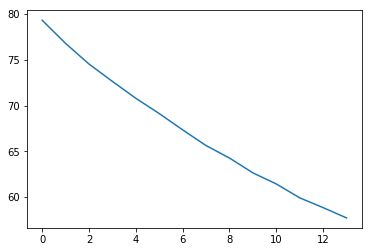

In [35]:
plt.plot(train_loss)

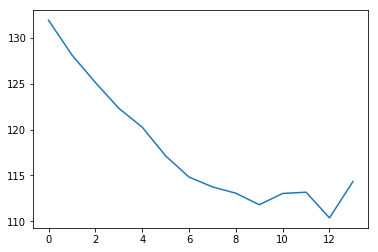

In [36]:
plt.plot(test_loss)

In [37]:
# final test
finalpred = []
finallb = []
for fold in range(NFOLD):
    testdf = traindata[traindata['fold']==fold]
    # 归一化
    ss = StandardScaler()
    ss.fit(testdf[features].values)
    X_test_std = ss.transform(testdf[features].values)
    testdf[norm_fe] = X_test_std
    testdf.reset_index(inplace=True)
    
    test_dataset = MyDataset(testdf)
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=True
    )
    device = 'cpu'
    model = DANN(n_class=3)
    model = model.to(device)
    model.load_state_dict(torch.load(f'best{fold}.pth')['model_state_dict'])
    model.eval()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    len_dataloader = len(test_loader)
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    acc = 0.0
    test_acc = 0
    test_preds = []
    test_lbs = []
    ts = tqdm_notebook(enumerate(test_loader), total=int(len(test_loader)))
    for ks,(inputs,label,domain) in ts:
        with torch.no_grad():

            inputs = inputs.to(device,dtype=torch.float)
            label = label.to(device, dtype=torch.long)
            domain = domain.to(device, dtype=torch.float)
            domain = domain.reshape(-1,1)
            testpred,do_outdomain = model(inputs,alpha)

            test_preds.extend(list(testpred.softmax(dim=-1).data.numpy()))
            test_lbs.extend(list(label.numpy()))

    test_preds = np.array(test_preds)
    test_preds = test_preds.argmax(axis=1)
    test_lbs = np.array(test_lbs)
    acc = np.sum(test_lbs==test_preds)/len(test_lbs)
    print('Testing pred acc: {:.5f}'.format(acc))
    finalpred.append(test_preds)
    finallb.append(test_lbs)

F:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
F:\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
F:\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


Epoch 13/49



Testing pred acc: 0.80012
Epoch 13/49



Testing pred acc: 0.82838
Epoch 13/49



Testing pred acc: 0.74301
Epoch 13/49



Testing pred acc: 0.86017
Epoch 13/49



Testing pred acc: 0.73506


In [39]:
finalpred = np.concatenate(finalpred)
finallb = np.concatenate(finallb)

In [40]:
acc = np.sum(finalpred==finallb)/len(finallb)
print(len(finallb))
print('Final Testing pred acc: {:.5f}'.format(acc))

16985
Final Testing pred acc: 0.79335
